In [41]:
# ------------------
# Imports and Setup
# ------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

from datetime import datetime

# Stonks Meme Aesthetic
plt.style.use("dark_background")

STONKS_GREEN = '#00ff9c'
STONKS_RED   = '#ff005c'
STONKS_BLUE  = '#00c3ff'
STONKS_PURP  = '#9d4edd'

In [43]:
# Set up figures directory
FIG_DIR = "/figures"
os.makedirs(FIG_DIR, exist_ok=True)

In [45]:
# FRED API Key
fred = Fred(api_key="9fb3507ccba20e766e4972a45c57c18c")

In [47]:
fred.get_series("SP500").tail()

2026-02-06    6932.30
2026-02-09    6964.82
2026-02-10    6941.81
2026-02-11    6941.47
2026-02-12    6832.76
dtype: float64

In [49]:
print(fred.api_key)

9fb3507ccba20e766e4972a45c57c18c


In [51]:
# ------------------
# Download the Data
# ------------------

series = {
    "stocks": "SP500",
    "bonds": "DGS10",
    "commodities": "DCOILWTICO",
    "vix": "VIXCLS"
}

data = {}

for name, code in series.items():
    print(f"Fetching {name} from FRED...")
    data[name] = fred.get_series(code)

df = pd.DataFrame(data)
df.index = pd.to_datetime(df.index)
df = df.dropna()

df.to_csv("data/raw/fred_series.csv")

df.tail()

Fetching stocks from FRED...
Fetching bonds from FRED...
Fetching commodities from FRED...
Fetching vix from FRED...


,stocks,bonds,commodities,vix
2026-02-03,6917.81,4.28,62.62,18.00
2026-02-04,6882.72,4.29,64.56,18.64
2026-02-05,6798.40,4.21,62.90,21.77
2026-02-06,6932.30,4.22,63.77,17.76
2026-02-09,6964.82,4.22,64.53,17.36


In [53]:
# Basic Summary Statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
stocks,2485.0,3825.403771,1316.098695,1895.58,2728.37,3752.75,4546.54,6978.60
bonds,2485.0,2.718841,1.182479,0.52,1.73,2.60,3.91,4.98
commodities,2485.0,64.136181,17.451793,-36.98,51.91,63.77,74.56,123.64
vix,2485.0,18.406109,7.321673,9.14,13.51,16.59,21.30,82.69


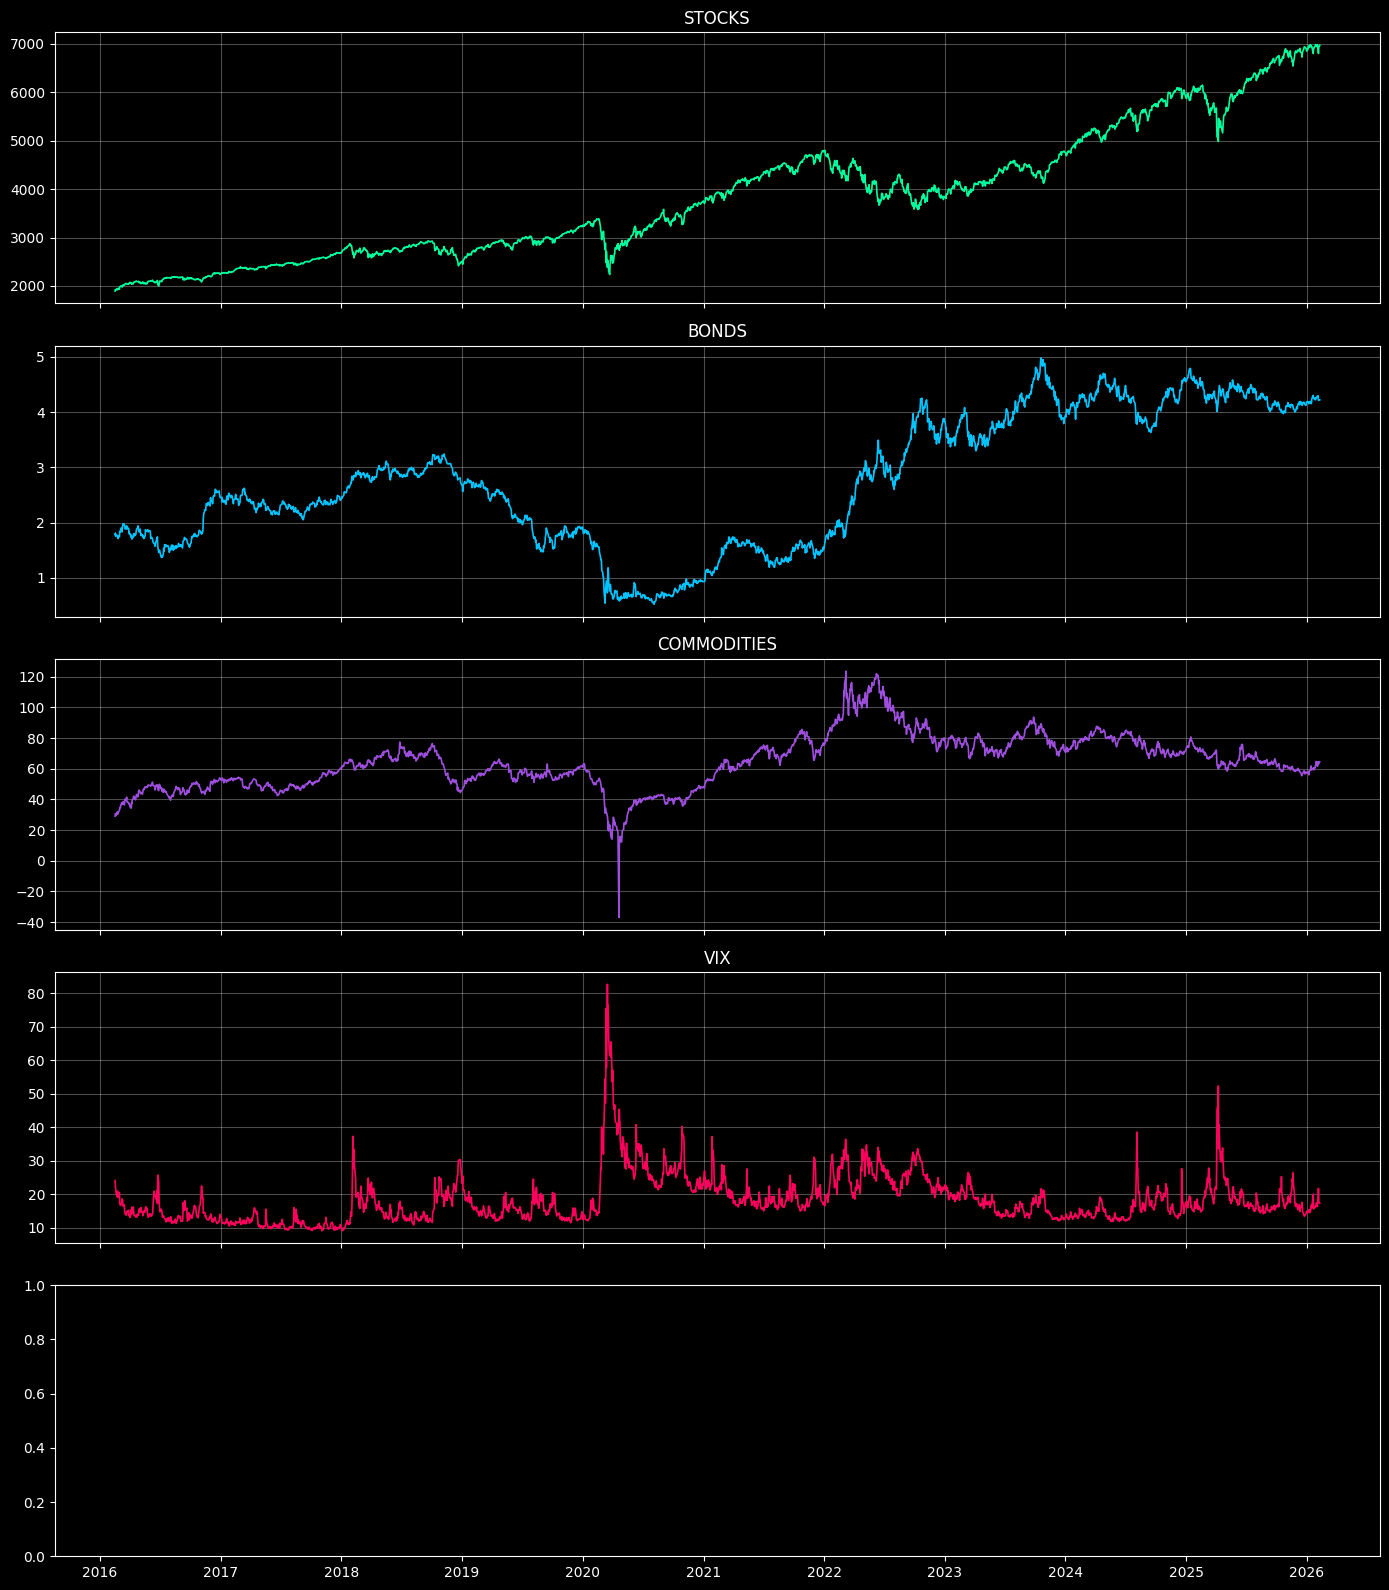

In [55]:
# Raw Timeseries Viz
fig, ax = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

colors = [STONKS_GREEN, STONKS_BLUE, STONKS_PURP, STONKS_RED, 'white']

for i, col in enumerate(df.columns):
    ax[i].plot(df.index, df[col], color=colors[i], lw=1.2)
    ax[i].set_title(col.upper(), fontsize=12)
    ax[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/raw_time_series.png", dpi=200)
plt.show()

In [56]:
# Caclulate Returns
returns = np.log(df).diff().dropna()
returns.head()

C:\Users\rfull\AppData\Roaming\Python\Python312\site-packages\pandas\core\internals\blocks.py:347: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,stocks,bonds,commodities,vix
2016-02-17,0.016346,0.016713,0.054592,-0.077592
2016-02-18,-0.004677,-0.033711,0.002929,-0.030492
2016-02-19,-0.000026,0.005698,-0.039104,-0.052656
2016-02-22,0.014351,0.005666,0.058416,-0.057646
2016-02-23,-0.012533,-0.017094,0.014871,0.079328


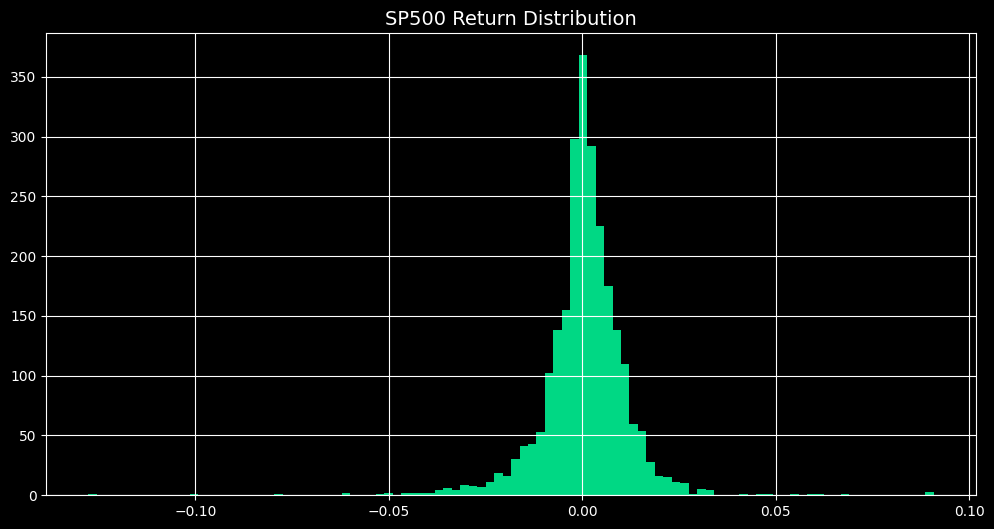

In [57]:
# Distribution of Returns
fig, ax = plt.subplots(figsize=(12,6))

returns["stocks"].hist(bins=100, color=STONKS_GREEN, alpha=0.85)
ax.set_title("SP500 Return Distribution", fontsize=14)

plt.savefig(f"{FIG_DIR}/sp500_return_distribution.png", dpi=200)
plt.show()

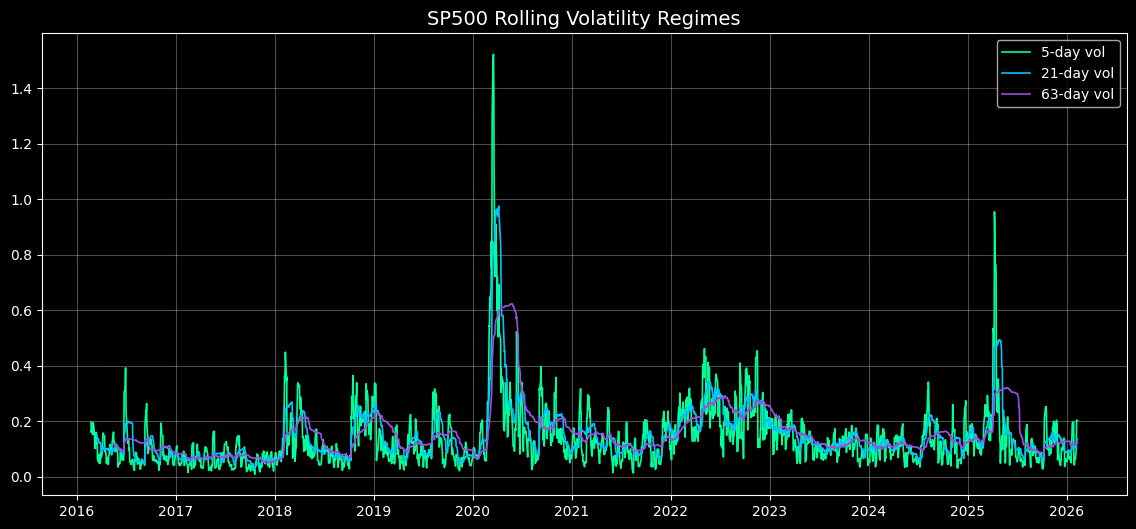

In [61]:
# Rolling Volatility Regimes
rolling_windows = [5, 21, 63]

fig, ax = plt.subplots(figsize=(14,6))

for w, c in zip(rolling_windows, [STONKS_GREEN, STONKS_BLUE, STONKS_PURP]):
    vol = returns["stocks"].rolling(w).std() * np.sqrt(252)
    ax.plot(vol, label=f"{w}-day vol", color=c, lw=1.2)

ax.set_title("SP500 Rolling Volatility Regimes", fontsize=14)
ax.legend()
ax.grid(alpha=0.3)

plt.savefig(f"{FIG_DIR}/sp500_volatility_regimes.png", dpi=200)
plt.show()

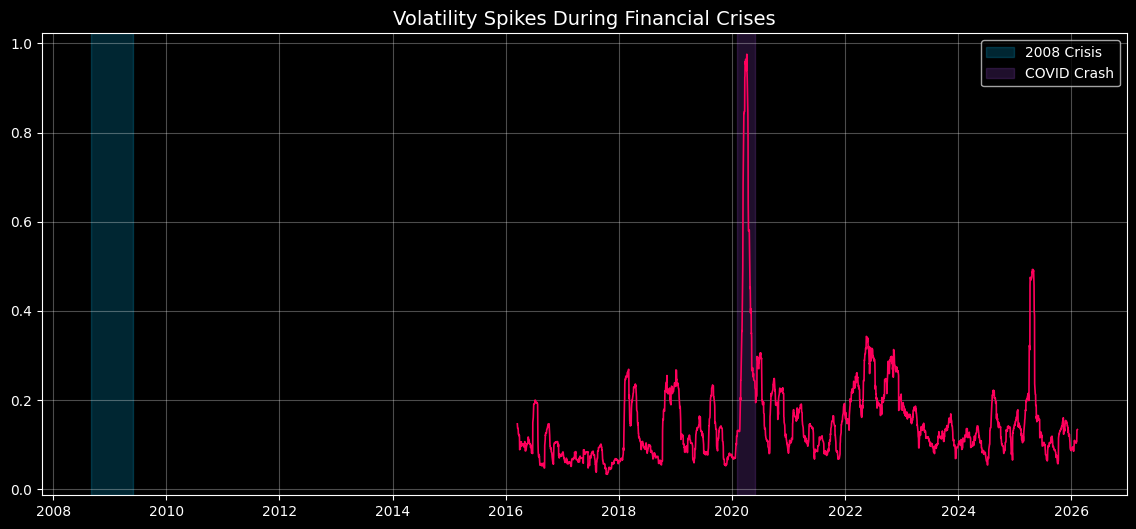

In [62]:
# Crisis Highlight
fig, ax = plt.subplots(figsize=(14,6))

vol_21 = returns["stocks"].rolling(21).std() * np.sqrt(252)
ax.plot(vol_21, color=STONKS_RED, lw=1.2)

ax.axvspan(pd.to_datetime("2008-09-01"), pd.to_datetime("2009-06-01"),
           color=STONKS_BLUE, alpha=0.2, label="2008 Crisis")

ax.axvspan(pd.to_datetime("2020-02-01"), pd.to_datetime("2020-06-01"),
           color=STONKS_PURP, alpha=0.2, label="COVID Crash")

ax.set_title("Volatility Spikes During Financial Crises", fontsize=14)
ax.legend()
ax.grid(alpha=0.3)

plt.savefig(f"{FIG_DIR}/crisis_volatility_spikes.png", dpi=200)
plt.show()

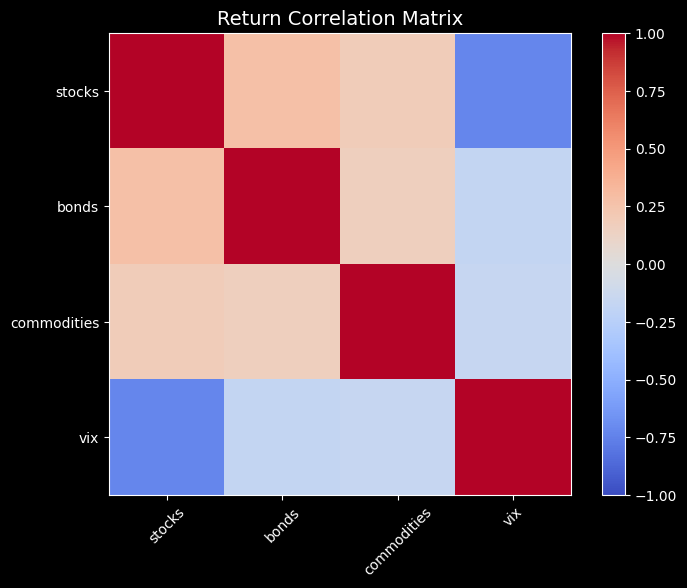

In [64]:
# Cross Asset Correlation
corr = returns.corr()

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45)
ax.set_yticklabels(corr.columns)

plt.colorbar(im, ax=ax, fraction=0.045)
ax.set_title("Return Correlation Matrix", fontsize=14)

plt.savefig(f"{FIG_DIR}/correlation_matrix.png", dpi=200)
plt.show()

In [67]:
# -------------------------------
# Volatility Feature Engineering
# -------------------------------

# Log returns
df["returns"] = np.log(df["stocks"]).diff()

# Realized volatility (rolling std of returns)
df["rv_5"]  = df["returns"].rolling(5).std()  * np.sqrt(252)
df["rv_21"] = df["returns"].rolling(21).std() * np.sqrt(252)

# Yield curve slope
df["curve_slope"] = df["bonds"]

# Target: next-day realized volatility
df["target_vol"] = df["rv_5"].shift(-1)

df = df.dropna()

df.tail()

,stocks,bonds,commodities,vix,returns,rv_5,rv_21,curve_slope,target_vol
2026-02-02,6976.44,4.29,61.60,16.34,0.005377,0.062968,0.103375,4.29,0.081368
2026-02-03,6917.81,4.28,62.62,18.00,-0.008440,0.081368,0.108210,4.28,0.082649
2026-02-04,6882.72,4.29,64.56,18.64,-0.005085,0.082649,0.107562,4.29,0.104597
2026-02-05,6798.40,4.21,62.90,21.77,-0.012327,0.104597,0.112852,4.21,0.203629
2026-02-06,6932.30,4.22,63.77,17.76,0.019504,0.203629,0.132853,4.22,0.202485


In [69]:
df.isna().sum()

stocks         0
bonds          0
commodities    0
vix            0
returns        0
rv_5           0
rv_21          0
curve_slope    0
target_vol     0
dtype: int64

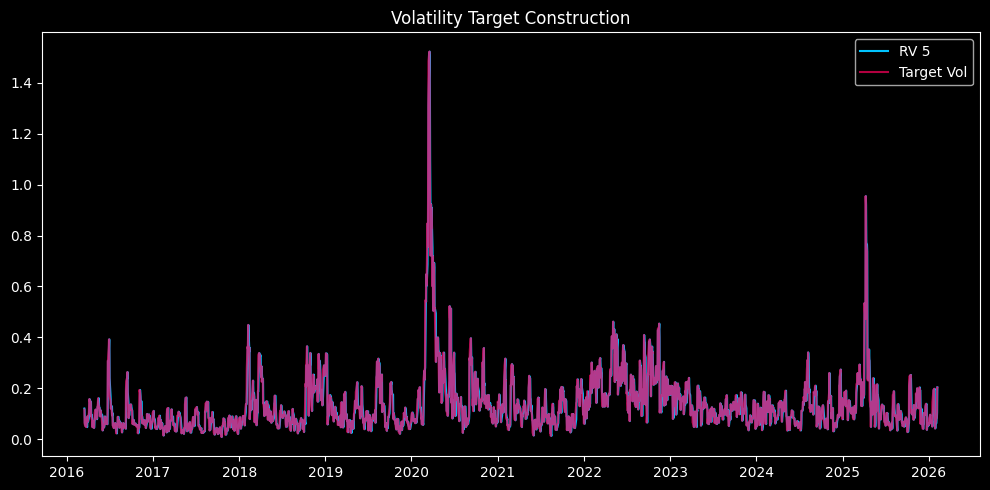

In [71]:
# Sanity Check Plot
plt.figure(figsize=(10,5))
plt.plot(df["rv_5"], label="RV 5", color=STONKS_BLUE)
plt.plot(df["target_vol"], label="Target Vol", color=STONKS_RED, alpha=0.7)
plt.title("Volatility Target Construction")
plt.legend()
plt.tight_layout()
plt.show()

In [73]:
from pathlib import Path

DATA_DIR = Path("../Neural Network for Volatility Forecasting/data/processed")
DATA_DIR.mkdir(exist_ok=True)

FEATURE_COLS = [
    "returns", "rv_5", "rv_21",
    "bonds", "curve_slope",
    "target_vol"
]

df[FEATURE_COLS].to_csv(DATA_DIR / "features.csv")

print("Saved:", DATA_DIR / "features.csv")

Saved: ..\Neural Network for Volatility Forecasting\data\processed\features.csv
